## Create sample grid for training data (code in neural.py)

In [ ]:
%pylab inline

In [ ]:
from Chempy.parameter import ModelParameters
from Chempy.cem_function import posterior_function_returning_predictions
from scipy.stats import norm as gaussian
import os
a = ModelParameters()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
## This calculates a list of 5 trial values for each parameter around the prior value, as an array of 6 lists which will be combined
# Set the desired Gaussian sigma values in the widths parameter (values > prior sigma are used to fully explore parameter space)
# Parameter values are chosen that are evenly distributed in the Gaussian probability space (e.g. 16.7, 33, 50 etc. percentile points)

N = a.training_size # No. data points per parameter
widths = a.training_widths # Gaussian widths for parameters

# Create 1d grid of data points equally spaced in probability space 
prob = np.linspace(1/(N+1), 1-1/(N+1), N)
grids = [gaussian.ppf(prob) for _ in range(N+1)] # Normalize to unit Gaussian
norm_grid = np.array(np.meshgrid(*grids)).T.reshape(-1,N+1)

# Create grid in parameter space
param_grid = [item*widths+a.p0 for item in norm_grid]

# Save grids
directory = 'Neural/'
if not os.path.exists(directory):
    os.makedirs(directory)
np.save(directory+'training_norm_grid.npy',norm_grid)
np.save(directory+'training_param_grid.npy',param_grid)

In [ ]:
# Create abundance output
param_grid = param_grid[:10] # For testing
training_abundances = []
for i,item in enumerate(param_grid):
    abundances,_ = posterior_function_returning_predictions((item,a))
    training_abundances.append(abundances)
    if i%100 == 0:
        print("Calculating abundance set %d of %d" %(i,len(param_grid)))
              
# Save abundance table
np.save('Neural/training_abundances.npy', training_abundances)


NOTES

- All code is now in neural.py file
- Should put changeable parameters e.g. number of choices for each parameter in parameter.py file - DONE
-  Find nicer way of using all rows from grid - DONE
- Check whether to use Karakas 10 or Karakas 16 - Karakas 10 for testing
- Automate number of traceable elements - just copy that from code - DONE

*This may be a useful reference https://arxiv.org/abs/1502.01852, for recommendation of ReLU units, with w = np.random.randn(n) x np.sqrt(2/n) for initialized weights, from Stanford course*

*Another useful reference: https://arxiv.org/abs/1412.6980 for 'Adam' learning method viz Stanford course*


## Create Verification / Testing Datasets

In [ ]:
a = ModelParameters()
names = ['verif','test']

In [ ]:
for i,name in enumerate(names): # Create two identically distributed datasets
    length = a.verif_test_sizes[i]
    param_grid = []
    # Distribute data with prior widths
    for _ in range(length):
        param_grid.append(np.random.normal(size = len(a.p0), loc = a.p0,
                                           scale = a.test_widths))
    np.save("Neural/"+name+"_param_grid.npy",param_grid)
    
    model_abundances = []
    for j,jtem in enumerate(param_grid):
        abundances,_ = posterior_function_returning_predictions((jtem,a))
        model_abundances.append(abundances)
        if j%100 == 0:
            print("Calculating %s abundance set %d of %d" %(name,j,length))
            
    # Save abundance table
    np.save("Neural/"+name+"_abundances.npy",model_abundances)

In [ ]:
for i,name in enumerate(names): # Create two identically distributed datasets
    length = a.verif_test_sizes[i]
    norm_grid = []
    # Distribute data with prior width, but normalized with trial_widths as before
    for _ in range(length):
        norm_grid.append(np.random.normal(size = len(a.p0),
                                          scale = np.array(a.test_widths)/np.array(a.training_widths)))
     
    # Convert data into normalized form
    np.save("Neural/"+name+"_norm_grid.npy",norm_grid)
    
    # Find the actual abundance grid
    param_grid = [item*a.training_widths+a.p0 for item in norm_grid]
    np.save("Neural/"+name+"_param_grid.npy",param_grid)
    
    model_abundances = []
    for j,jtem in enumerate(param_grid[:10]):
        abundances,_ = posterior_function_returning_predictions((jtem,a))
        model_abundances.append(abundances)
        if j%2 == 0:
            print("Calculating %s abundance set %d of %d" %(name,j,length))
            
    # Save abundance table
    np.save("Neural/"+name+"_abundances.npy",model_abundances)

## Create the Neural Network

In [ ]:
%pylab inline
import numpy as np
import sys
import os
import torch # Import PyTorch
from torch.autograd import Variable
from Chempy.parameter import ModelParameters

In [ ]:
a = ModelParameters()

n_train = a.training_size**len(a.p0) # Training data points
n_neurons = a.neurons # No. neurons in layers

# Load pre-processed training data
tr_input = np.load('Neural/training_norm_grid.npy')
tr_output = np.load('Neural/training_abundances.npy')

# Calculate input dimension
dim_in = tr_input.shape[1]
dim_out = tr_output.shape[1]

# Convert to torch variables
tr_input = Variable(torch.from_numpy(tr_input)).type(torch.FloatTensor)
tr_output = Variable(torch.from_numpy(tr_output), requires_grad=False).type(torch.FloatTensor)

In [ ]:
## Calculate neural network - use one hidden layer and no. neurons specified in parameter.py.
# CHANGE these hyperparameters if needed

# Remove the below ##############
model = []
a.learning_rate = 0.001 
##############################

model = torch.nn.Sequential(
        torch.nn.Linear(dim_in, a.neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(a.neurons,dim_out)
)
loss_fn = torch.nn.L1Loss(size_average=True)

# Use Adam optimizer with specified learning rate in parameter.py
optimizer = torch.optim.Adam(model.parameters(),lr = a.learning_rate)

In [ ]:
# Convergence counter
current_loss = 1000 # High inital loss set
count = 0
t = 0

# Used for plotting loss
losslog = []
epoch = []

In [ ]:
# Train the neural netowrk
for i in range(a.epochs):
    pred_output = model(tr_input)
    loss = loss_fn(pred_output,tr_output)
    optimizer.zero_grad() # Zero gradients initially
    loss.backward() # Backpropagate
    optimizer.step() # Update via Adam method
    
   
    # Print cost
    if i % 100 == 0:
        print(i)
        #print(loss.data[0])
        losslog.append(loss.data[0])
        epoch.append(i)
           
    

In [ ]:
plt.plot(epoch, losslog)

In [ ]:
# Convert back to numpy arrays
model_numpy = []
for param in model.parameters():
    model_numpy.append(param.data.numpy())
    
w_array_0 = model_numpy[0]
b_array_0 = model_numpy[1]
w_array_1 = model_numpy[2]
b_array_1 = model_numpy[3]

# Save parameters
np.savez("Neural/neural_model.npz",
        w_array_0 = w_array_0,
        w_array_1 = w_array_1,
        b_array_0 = b_array_0,
        b_array_1 = b_array_1)

In [ ]:
def neural_output(test_input):
    """ This function will calculate the neural network predicted output.
    The neural network must be trained first.
    
    Inputs: 
    test_input - Array containing unnormalized parameter values
    neural_coeffs - Neural network weights, stored in neural_model.npz file
    
    Output: Neural network abundance prediction
    """
    
    # Load in most recent neural coefficients
    neural_coeffs = np.load('Neural/neural_model.npz')
    w_array_0 = neural_coeffs['w_array_0']
    w_array_1 = neural_coeffs['w_array_1']
    b_array_0 = neural_coeffs['b_array_0']
    b_array_1 = neural_coeffs['b_array_1']
    
    # Normalize data for neural network input
    norm_data = (test_input - a.p0)/np.array(a.training_widths)
    
    # Calculate neural network output
    hidden = np.maximum(0,np.dot(w_array_0, norm_data) + b_array_0)
    output = np.dot(w_array_1, hidden) + b_array_1
    
    return output

In [ ]:
from Chempy.cem_function import posterior_function_returning_predictions

In [ ]:
# Calculate average error using 1000 epochs for Verification dataset
verif_param = np.load('Neural/verif_param_grid.npy')
verif_abundances = np.load('Neural/verif_abundances.npy')

for i in range(a.verif_test_sizes[0]):
    predicted_abundances = neural_output(verif_param[i])
    # Compute percentage error for each element
    

In [ ]:
# Plot the outputs

%pylab inline 
# For testing

x = np.arange(len(model_out))
plt.plot(x,model_out,'r',label = 'Chempy')
plt.plot(x,prediction_out,'b',label='Neural')
plt.legend()
plt.show()

**TO DO**
- Vary optimizer, ReLU function, L1Loss to see which gives best results - DONE
- Which regularization method are we using??
- Check initialized weights - sqrt(2/n) thing
- Plot loss function against epoch - DONE
- Plot accuracy on verification dataset against epoch
- Vary learning_rate - DONE
- Plot accuracy on test data as 2D coloured plot in parameter space for each pair - DONE

**MUST change the predictions to output in NON normalized space**

**NB: if change ReLU function, must change in update above AND output**

## Corner plot

In [52]:
# Load verification dataset
verif_param = np.load('Neural/verif_param_grid.npy')
verif_abundances = np.load('Neural/verif_abundances.npy')

# Calculate average percentage error in sample per element
from Chempy.neural import neural_output
error = []

for i in range(len(verif_param)):
    predicted_abundances = neural_output(verif_param[i])
    # Compute percentage error for each element
    error.append(np.absolute(predicted_abundances-verif_abundances[i]))

# This contains absolute median error for each parameter set
param_error = np.median(error,axis=1)

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f13dc3e3668>>
Traceback (most recent call last):
  File "/home/philcox/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py", line 208, in __del__
    self.close()
  File "/home/philcox/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py", line 199, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


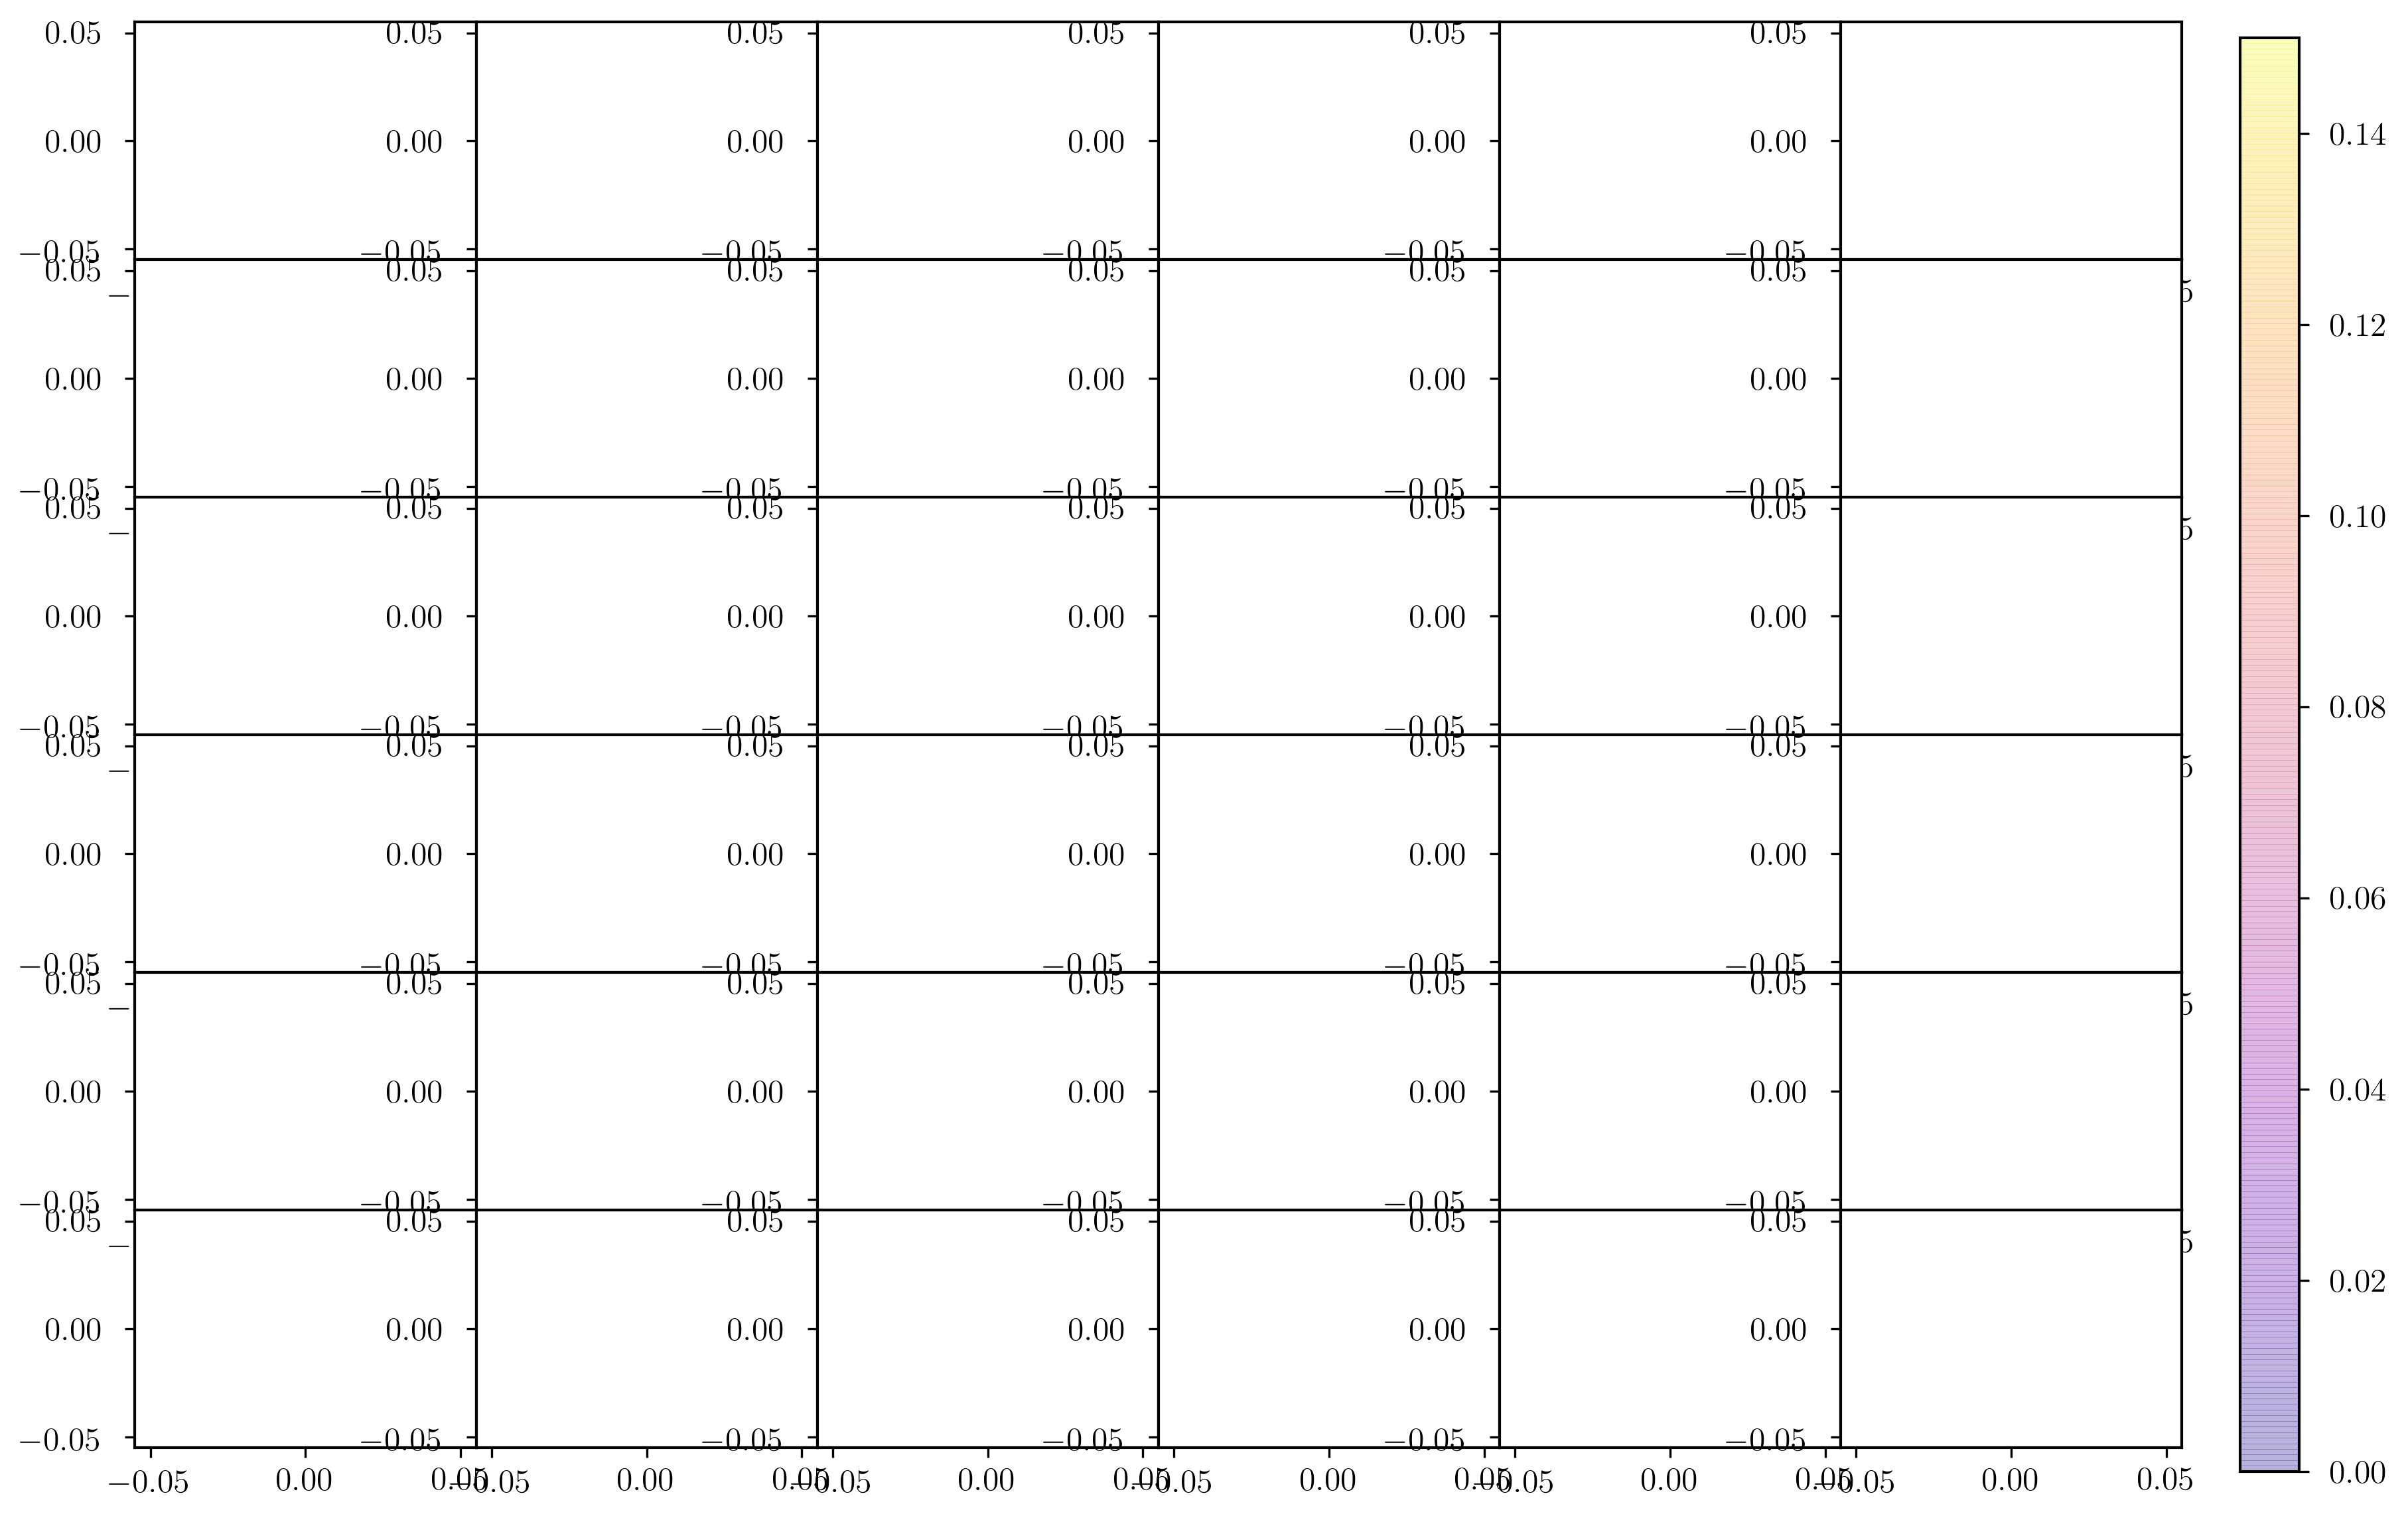

In [53]:
# Create corner plot infrastructure
from Chempy.parameter import ModelParameters
from Chempy.neural import neural_errors
a=ModelParameters()
param_error = neural_errors('test')
# Load verification dataset
data_v = np.array(np.load('Neural/verif_param_grid.npy'))
data_tr = np.array(np.load('Neural/training_param_grid.npy'))


parameter_names = [r'$\alpha_\mathrm{IMF}$',r'$\log_{10}(\mathrm{N_{Ia}})$',
                   r'$\log_{10}(\tau_\mathrm{Ia})$',r'$\log_{10}(\mathrm{SFE})$',
                   r'$\log_{10}(\mathrm{SFR_{peak}})$',r'x_{out}']

# Set up plot
plt.clf()
text_size = 12
plt.rc('font', family='serif',size = text_size)
plt.rc('xtick', labelsize=text_size)
plt.rc('ytick', labelsize=text_size)
plt.rc('axes', labelsize=text_size, lw=1.0)
plt.rc('lines', linewidth = 1)
plt.rcParams['ytick.major.pad']='8'
plt.rcParams['text.latex.preamble']=[r"\usepackage{libertine}"]
params = {'text.usetex' : True,
          'font.family' : 'libertine',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params)

fig,axes = plt.subplots(nrows = len(a.p0), ncols = len(a.p0),figsize=(14.69,8.0),dpi=300)
alpha = 0.5
lw=2 # Linewidth
left = 0.1 # Left side of subplots
right = 0.8 # Right side
bottom = 0.075
top = 0.97
wspace = 0.0 # blankspace width between subplots
hspace = 0.0 # blankspace height between subplots
color_max = 0.15
plt.subplots_adjust(left=left,bottom=bottom,right=right,top=top,wspace=wspace,hspace=hspace)


for i in range(len(a.p0)):
    for j in range(len(a.p0)):
        axes[i,j].locator_params(nbins=4)
        continue
        if j==1:
            axes[i,j].locator_params(nbins=4)
            continue
        if i==j:
            counts,edges = np.histogram(np.asarray(data_v[:,j]),bins=10)
            max_count = float(np.max(counts))
            counts = np.divide(counts,max_count)
            median = np.zeros(len(edges)-1)
            for k in range(len(edges)-1):
                choice = np.logical_and(np.greater(data_v[:,j],edges[k]),np.less(data_v[:100,j],edges[k+1]))
                error=np.extract(choice,param_error)
                if len(error) != 0:
                    median[k] = np.median(error)
            colors = cm.plasma(median/color_max)
            axes[i,j].bar(left = edges[:-1], height=counts, width = edges[1]-edges[0],
                          color=colors,alpha=alpha, linewidth=0)
            axes[i,j].set_xlim(min(data_v[:,j]),max(data_v[:,j]))
            axes[i,j].set_ylim(0,1.05)
            if j !=0:
                plt.setp(axes[i,j].get_yticklabels(), visible=False)
            axes[i,j].vlines(np.percentile(data_v[:,j],15.865),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw,linestyle = 'dashed')    
            axes[i,j].vlines(np.percentile(data_v[:,j],100-15.865),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw,linestyle = 'dashed')    
            axes[i,j].vlines(np.percentile(data_v[:,j],50),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw)
        if i>j:
            if j !=0:
                plt.setp(axes[i,j].get_yticklabels(), visible=False)
            P1 = axes[i,j].scatter(data_v[:,i],data_v[:,j],marker='.',alpha=0.3,
                                   c=param_error,vmin=0,vmax=color_max,cmap='plasma',s=1)
            P2 = axes[i,j].scatter(data_tr[:,i],data_tr[:,j],c='k',marker='+',s=80)
            axes[i,j].set_xlim(min(data_tr[:,i])-0.1,max(data_tr[:,i])+0.1)
            axes[i,j].set_ylim(min(data_tr[:,j])-0.1,max(data_tr[:,j])+0.1)
        if j>i:
            axes[i,j].axis('off')
        if i == len(a.p0)-1:
            axes[i,j].set_xlabel(parameter_names[j])
        if j ==0:
            axes[i,j].set_ylabel(parameter_names[i])
        if i==2 and j == 1:
            cplot = axes[i,j].scatter(data_v[:,i],data_v[:,j],marker='.',alpha=0.3,
                                      c=param_error,vmin=0,vmax=color_max,cmap='plasma',s=1)
cax=fig.add_axes([0.82,0.06,0.02,0.9])
plt.colorbar(cplot,cax=cax)
plt.show()
#fig.savefig('Neural/corner_parameter_plot.png',dpi=300,bbox_inches='tight')

## Single Plot

In [7]:
%pylab inline
from Chempy.neural import neural_errors
param_error = neural_errors('test')

Populating the interactive namespace from numpy and matplotlib


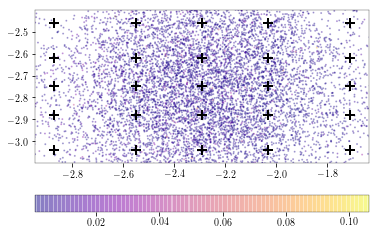

In [32]:
plt.clf()
plt.rc('axes', labelsize=16, lw=0.3)
plt.rc('text',usetex=True)

# Create plot

data_tr = np.load('Neural/training_param_grid.npy')
data = np.load('Neural/test_param_grid.npy')
error = param_error

# Use only 2 axes now
x_tr = [item[0] for item in data_tr]
y_tr = [item[1] for item in data_tr]
x = [item[0] for item in data]
y = [item[1] for item in data]

fig = plt.figure()
ax = fig.add_subplot(111)
P1 = ax.scatter(x_tr,y_tr,c='k',marker='+',s=120)
ax = plt.gca()
# Store axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()
P2 = ax.scatter(x,y,marker='o',alpha=0.3,
                c=error,s=1,cmap='plasma')
# Replot this on top
P1 = ax.scatter(x_tr,y_tr,c='k',marker='+',alpha=1,s=120)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig.colorbar(P2,orientation='horizontal')
plt.show()

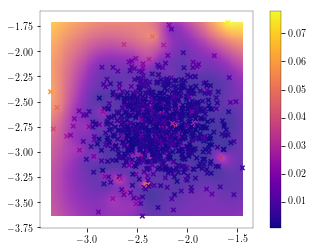

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

x=np.array(x[:1000])
y=np.array(y[:1000])
z=np.array(param_error[:1000])
# Generate data:

# Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), 200), np.linspace(y.min(), y.max(), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)

plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()],cmap='plasma',alpha=0.8)
plt.scatter(x, y, marker='x',s=20,c=z,cmap='plasma')
plt.colorbar()
plt.show()

In [35]:
np.load('Chempy/input/stars/Proto-sun.npy')

array([ ( 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0. ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  0.  ,  4.56),
       ( 0.02,  0.06,  0.06,  0.06,  0.07,  0.11,  0.05,  0.05,  0.04,  0.04,  0.04,  0.04,  0.14,  0.1,  0.05,  0.06,  0.09,  0.05,  0.05,  0.05,  0.08,  0.05,  0.01)], 
      dtype=[('He', '<f8'), ('C', '<f8'), ('N', '<f8'), ('O', '<f8'), ('F', '<f8'), ('Ne', '<f8'), ('Na', '<f8'), ('Mg', '<f8'), ('Al', '<f8'), ('Si', '<f8'), ('P', '<f8'), ('S', '<f8'), ('Ar', '<f8'), ('K', '<f8'), ('Ca', '<f8'), ('Ti', '<f8'), ('V', '<f8'), ('Cr', '<f8'), ('Mn', '<f8'), ('Fe', '<f8'), ('Co', '<f8'), ('Ni', '<f8'), ('age', '<f8')])

## Spare Code


plt.clf()
plt.rc('axes', labelsize=16, lw=0.3)
plt.rc('text',usetex=True)

#Create plot

data_tr = np.load('Neural/training_param_grid.npy')
data_v = np.load('Neural/verif_param_grid.npy')
error = param_error

#Use only 2 axes now

x_tr = [item[0] for item in data_tr]
y_tr = [item[3] for item in data_tr]
x_v = [item[0] for item in data_v]
y_v = [item[3] for item in data_v]

fig = plt.figure()
ax = fig.add_subplot(111)
P1 = ax.scatter(x_tr,y_tr,c='k',marker='+',s=120)
ax = plt.gca()
#Store axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()
P2 = ax.scatter(x_v,y_v,marker='o',alpha=0.3,
                c=error,s=2,cmap='plasma')
#Replot this on top

P1 = ax.scatter(x_tr,y_tr,c='k',marker='+',alpha=1,s=120)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig.colorbar(P2,orientation='horizontal')
plt.show()

In [1]:
%pylab inline
from Chempy.parameter import ModelParameters
a = ModelParameters()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from Chempy.cem_function import cem_real2
ab2,na2=cem_real2(a)

In [ ]:
from Chempy.cem_function import posterior_function_predictions
p,ab,na=posterior_function_predictions(a.p0,a)

In [4]:
from Chempy.neural import neural_output

In [5]:
from Chempy.neural import neural_output
names = a.elements_to_trace
neural_abundances = neural_output(a.p0)
names.append('Zcorona')
names.append('SNratio')
abundances=np.zeros((len(names),1))
j=0
for i,name in enumerate(names):
    if name in a.neural_names:
        abundances[i] =  neural_abundances[j]
        j = j+1
# Hack to fix bug
del a
a=ModelParameters()


In [6]:
abundances

array([[ 0.46697587],
       [ 0.10105052],
       [ 0.        ],
       [ 0.        ],
       [-0.19060413],
       [ 0.01870418],
       [ 0.        ],
       [-0.11551477],
       [ 0.1340243 ],
       [ 0.        ],
       [-0.07493073],
       [ 0.23446705],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.1770244 ],
       [-0.51326051],
       [ 0.        ],
       [ 0.19791537],
       [ 0.15522758],
       [ 0.12359748],
       [ 0.69310467],
       [ 0.45968022],
       [ 0.16384264],
       [ 0.3627465 ],
       [ 0.40606143],
       [ 0.24930715],
       [ 0.        ],
       [ 0.3018295 ],
       [-0.27624317],
       [-0.16511348],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [ ]:
abundances=np.zeros((len(names),1))

In [ ]:
j=0
for i,name in enumerate(names):
    if name in a.neural_names:
        abundances[i] =  neural_abundances[j]
        print(name)
        j = j+1

In [ ]:
ab2

In [ ]:
sol_dat=np.load('Chempy/input/stars/Proto-sun.npy')

In [ ]:
sol_dat.dtype.names

In [ ]:
neural_list = []
for item in a.elements_to_trace:
    if item in list(sol_dat.dtype.names):
        neural_list.append(item)

In [ ]:
neural_list

In [60]:
dt = np.dtype('a13,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8')
z = np.genfromtxt('Chempy/input/yields/Frischknecht16/yields_total.txt',skip_header=62,dtype=dt,names=True)


AttributeError: 'numpy.ndarray' object has no attribute 'names'

In [ ]:
def Nomoto2013_net(self):
		'''
		Nomoto2013 sn2 yields from 13Msun onwards
		'''
		import numpy.lib.recfunctions as rcfuncs

		dt = np.dtype('a13,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8')
		yield_tables = {}
		self.metallicities = [0.0500,0.0200,0.0080,0.0040,0.0010]
		self.masses = np.array((13,15,18,20,25,30,40))
		z = np.genfromtxt(localpath + 'input/yields/Nomoto2013/nomoto_2013_z=0.0200.dat',dtype=dt,names = True)
		
		yield_tables_dict = {}
		for item in self.metallicities:
			z = np.genfromtxt(localpath + 'input/yields/Nomoto2013/nomoto_2013_z=%.4f.dat' %(item),dtype=dt,names = True)
			yield_tables_dict[item]=z

		hydrogen_list = ['H__1','H__2']
		helium_list = ['He_3','He_4']
		lithium_list = ['Li_6','Li_7']
		berillium_list = ['Be_9']
		boron_list = ['B_10','B_11']
		carbon_list = ['C_12','C_13']
		nitrogen_list = ['N_14','N_15']
		oxygen_list = ['O_16','O_17','O_18']
		fluorin_list = ['F_19']
		neon_list = ['Ne20','Ne21','Ne22']
		sodium_list = ['Na23']
		magnesium_list = ['Mg24','Mg25','Mg26']
		aluminium_list = ['Al27']
		silicon_list = ['Si28','Si29','Si30']
		phosphorus_list = ['P_31']
		sulfur_list = ['S_32','S_33','S_34','S_36']
		chlorine_list = ['Cl35','Cl37']
		argon_list = ['Ar36','Ar38','Ar40']
		potassium_list = ['K_39','K_41']
		calcium_list = ['K_40','Ca40','Ca42','Ca43','Ca44','Ca46','Ca48']
		scandium_list = ['Sc45']
		titanium_list = ['Ti46','Ti47','Ti48','Ti49','Ti50']
		vanadium_list = ['V_50','V_51']
		chromium_list = ['Cr50','Cr52','Cr53','Cr54']
		manganese_list = ['Mn55']
		iron_list = ['Fe54', 'Fe56','Fe57','Fe58']
		cobalt_list = ['Co59']
		nickel_list = ['Ni58','Ni60','Ni61','Ni62','Ni64']
		copper_list = ['Cu63','Cu65']
		zinc_list = ['Zn64','Zn66','Zn67','Zn68','Zn70']
		gallium_list = ['Ga69','Ga71']
		germanium_list = ['Ge70','Ge72','Ge73','Ge74']

		indexing = {}
		indexing['H'] = hydrogen_list
		indexing['He'] = helium_list
		indexing['Li'] = lithium_list
		indexing['Be'] = berillium_list
		indexing['B'] = boron_list
		
		indexing['C'] = carbon_list
		indexing['N'] = nitrogen_list
		indexing['O'] = oxygen_list
		indexing['F'] = fluorin_list
		indexing['Ne'] = neon_list
		indexing['Na'] = sodium_list
		indexing['Mg'] = magnesium_list
		indexing['Al'] = aluminium_list
		indexing['Si'] = silicon_list
		indexing['P'] = phosphorus_list
		indexing['S'] = sulfur_list
		indexing['Cl'] = chlorine_list
		indexing['Ar'] = argon_list
		indexing['K'] = potassium_list
		indexing['Ca'] = calcium_list
		indexing['Sc'] = scandium_list
		indexing['Ti'] = titanium_list
		indexing['V'] = vanadium_list
		indexing['Cr'] = chromium_list
		indexing['Mn'] = manganese_list
		indexing['Fe'] = iron_list
		indexing['Co'] = cobalt_list
		indexing['Ni'] = nickel_list
		indexing['Cu'] = copper_list
		indexing['Zn'] = zinc_list
		indexing['Ga'] = gallium_list
		indexing['Ge'] = germanium_list

		self.elements = list(indexing.keys())
		### restructuring the tables such that it looks like the sn2 dictionary: basic_agb[metallicicty][element]
		yield_tables_final_structure = {}
		for metallicity_index,metallicity in enumerate(self.metallicities):

			yield_tables_final_structure[metallicity] = np.load(localpath + 'input/yields/Nomoto2013/nomoto_net_met_ind_%d.npy' %(metallicity_index))
		self.table = yield_tables_final_structure
